## Imports
We load NumPy for array math, pandas for tables, Matplotlib for production charts, SciPy's stats module for reliability quantiles, and CVXPY for solving the convex production planning problem.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp
from typing import Dict, Any, Tuple

## Production System Class

**Purpose:** Models a factory with multiple machines, each having unique cost curves and capacity constraints.

**Key Features:**
- **Quadratic Cost Model:** Each machine follows cost function: `C(x) = αx² + βx + γ`
- **Random Generation:** Creates realistic heterogeneous machines with different efficiency profiles
- **Reproducibility:** Fixed seed ensures consistent results across runs

**Cost Parameters:**
- `α` (alpha): Quadratic term — models increasing inefficiency at higher production
- `β` (beta): Linear term — represents per-unit variable costs (fuel, materials)
- `γ` (gamma): Fixed costs — startup/maintenance costs independent of production

**Methods:**
- `describe()`: Returns DataFrame with all machine parameters
- `total_capacity()`: Calculates system-wide maximum production capability

In [73]:
class ProductionSystem:
    """
    Factory model holding production machine cost curves and capacity limits.

    Each machine i has cost: C_i(x_i) = alpha_i x_i^2 + beta_i x_i + gamma_i
    with 0 <= x_i <= u_i (minimum assumed zero).
    """
    def __init__(self, n_machines: int = 5, seed: int = 42,
                 alpha_bounds: Tuple[float, float] = (0.05, 0.2),
                 beta_bounds: Tuple[float, float] = (2.0, 5.0),
                 gamma_bounds: Tuple[float, float] = (10.0, 20.0),
                 capacity_bounds: Tuple[float, float] = (50.0, 150.0)):
        rng = np.random.default_rng(seed)
        self.n = n_machines
        # Quadratic production cost curvature
        self.alpha = rng.uniform(alpha_bounds[0], alpha_bounds[1], n_machines)
        # Linear production cost slope
        self.beta = rng.uniform(beta_bounds[0], beta_bounds[1], n_machines)
        # Fixed cost component
        self.gamma = rng.uniform(gamma_bounds[0], gamma_bounds[1], n_machines)
        # Lower/upper production capacity (units)
        self.l = np.zeros(n_machines)
        self.u = rng.uniform(capacity_bounds[0], capacity_bounds[1], n_machines)

    def describe(self) -> pd.DataFrame:
        machines = np.arange(1, self.n + 1)
        data = {
            "alpha": self.alpha,
            "beta": self.beta,
            "gamma": self.gamma,
            "min_cap": self.l,
            "max_capacity": self.u,
        }
        return pd.DataFrame(data, index=machines).rename_axis("production_machine")

    def total_capacity(self) -> float:
        return float(np.sum(self.u))

## Production Planning Solver (`solve_dispatch`)

Determines **cost‑minimizing production levels** across machines while meeting a reliability‑adjusted customer demand target.

### Purpose
Translate uncertain demand (mean + variability + chosen service level) into a deterministic **effective demand** `D_eff`, then solve a convex program that yields optimal production and economic (dual) signals.

### Inputs
| Name | Type | Description |
|------|------|-------------|
| `system` | ProductionSystem | Factory with cost coefficients & capacity bounds |
| `mu_D` | float | Mean (expected) demand (≥ 0) |
| `sigma_D` | float | Demand standard deviation (≥ 0) |
| `reliability` | float | Target service level probability (0–1 open interval) |
| `mode` | str | `"normal"` (Gaussian quantile) or `"robust"` (Cantelli/Chebyshev) |

### Reliability Buffering
Let `alpha_risk = 1 - reliability`.
- Normal: `D_eff = mu_D + z * sigma_D` where `z` is the standard normal quantile.
- Robust: `D_eff = mu_D + k * sigma_D` with `k = sqrt((1 - alpha_risk)/alpha_risk)` (one‑sided Cantelli bound). 
If `D_eff` exceeds total capacity the problem is infeasible and an error is raised.

### Optimization Model
Minimize quadratic + linear variable cost (fixed costs added post‑solution):
```
min   Σ_i (alpha_i x_i^2 + beta_i x_i)
s.t. Σ_i x_i ≥ D_eff
     0 ≤ x_i ≤ u_i
```
Convexity (positive quadratic curvature) enables efficient solution via OSQP.

### Returned Dictionary
| Key | Meaning |
|-----|---------|
| `status` | Solver status (`optimal`, etc.) |
| `x` | Optimal production vector |
| `cost` | Total cost incl. fixed γ terms |
| `objective` | Variable cost portion (without γ) |
| `D_eff` | Reliability‑adjusted demand enforced |
| `lambda` | Dual of demand constraint (shadow price per required unit) |
| `nu_u` | Duals of upper bounds (capacity scarcity signals) |
| `nu_l` | Duals of lower bounds (often zero here) |

### Economic Interpretation
- High `lambda` ⇒ system tight; marginal cost to serve extra demand is large.
- Positive entries in `nu_u` ⇒ machines at capacity; candidates for expansion or efficiency improvements.
- `cost - objective` ⇒ total fixed overhead impact.

### Validation & Errors
Errors raised for: negative demand stats, reliability outside (0,1), unsupported mode, or infeasible `D_eff`. Non‑optimal statuses return only `{"status": ...}` (no economics).

### Usage Flow
1. Build a `ProductionSystem`.
2. Call `solve_dispatch(system, mu, sigma, reliability=0.95, mode="normal")`.
3. Inspect `x`, `lambda`, `nu_u` for operational & pricing insights.


In [74]:
def solve_dispatch(
    system: ProductionSystem,
    mu_D: float,
    sigma_D: float,
    reliability: float = 0.95,
    mode: str = "normal",
) -> Dict[str, Any]:
    """Solve the stochastic production planning problem under Normal or Chebyshev reliability buffering.

    We convert a probabilistic customer demand requirement into a deterministic
    effective demand D_eff then solve:
        minimize   sum_i (alpha_i x_i^2 + beta_i x_i)
        subject to sum_i x_i >= D_eff
                   0 <= x_i <= max_capacity_i
    Fixed costs gamma_i are added after solving for reporting.

    Returns dictionary with optimal production vector, total cost (incl. gamma),
    effective demand enforced, and dual multipliers:
      lambda : shadow price of 1 additional unit of required demand
      nu_u   : scarcity indicator per machine at its capacity
      nu_l   : lower bound duals (typically zero here)
    """
    if sigma_D < 0 or mu_D < 0:
        raise ValueError("Demand statistics must be non-negative")
    if not 0.0 < reliability < 1.0:
        raise ValueError("Reliability must lie strictly between 0 and 1")

    x = cp.Variable(system.n)
    alpha_risk = 1.0 - reliability

    if mode == "normal":
        z_score = stats.norm.ppf(reliability)
        D_eff = mu_D + z_score * sigma_D
    elif mode == "robust":
        k_robust = np.sqrt((1 - alpha_risk) / alpha_risk)
        D_eff = mu_D + k_robust * sigma_D
    else:
        raise ValueError("Mode must be 'normal' or 'robust'")

    if D_eff > system.total_capacity() + 1e-6:
        raise ValueError("Effective customer demand exceeds installed production capacity")

    objective = cp.Minimize(
        cp.sum(cp.multiply(system.alpha, x**2) + cp.multiply(system.beta, x))
    )

    c_demand = [cp.sum(x) >= D_eff]
    c_upper = [x <= system.u]
    c_lower = [x >= system.l]
    constraints = c_demand + c_upper + c_lower

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)

    if prob.status not in {"optimal", "optimal_inaccurate"}:
        return {"status": prob.status}

    dispatch = x.value
    total_cost = float(
        np.sum(system.alpha * dispatch**2 + system.beta * dispatch + system.gamma)
    )

    return {
        "status": prob.status,
        "x": dispatch,
        "cost": total_cost,
        "objective": prob.value,
        "D_eff": float(D_eff),
        "lambda": c_demand[0].dual_value,
        "nu_u": c_upper[0].dual_value,
        "nu_l": c_lower[0].dual_value,
    }

## KKT Verification
`verify_kkt` receives the system and solver results, computes the stationarity residual (`grad_f - λ + ν⁺ - ν⁻`) and complementary slackness (`(∑x - D_eff) * λ`), prints both, and reports whether they are below tolerance.

In [75]:
def verify_kkt(system: ProductionSystem, res: Dict[str, Any], tol: float = 1e-4) -> Dict[str, float]:
    """Compute stationarity and complementary slackness residuals."""
    
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        print("Cannot verify KKT: solution unavailable.")
        return {}
    
    dispatch = res["x"]
    lam = res["lambda"]
    nu_u = res["nu_u"]
    nu_l = res["nu_l"]
    
    grad_f = 2 * system.alpha * dispatch + system.beta
    stationarity_residual = grad_f - lam + nu_u - nu_l
    max_stationarity = float(np.max(np.abs(stationarity_residual)))
    
    total_prod = float(np.sum(dispatch))
    slack = total_prod - res["D_eff"]
    comp_slack_error = float(abs(slack * lam))
    
    print("\n--- KKT CHECK ---")
    print(f"Stationarity residual: {max_stationarity:.2e}")
    print(f"Complementary slackness residual: {comp_slack_error:.2e}")
    
    if max_stationarity < tol and comp_slack_error < tol:
        print("KKT conditions satisfied within tolerance.")
    else:
        print("Warning: residuals exceed tolerance.")
    
    return {"stationarity": max_stationarity, "slackness": comp_slack_error}

In [76]:
# 1. Create the factory
my_factory = ProductionSystem(n_machines=5)

# 2. Define the customer demand scenario
MEAN_DEMAND = 300
SIGMA = 30
RELIABILITY = 0.95  # 95% service level

# 3. Run the Normal (Gaussian) buffering model
print("--- NORMAL MODEL (Gaussian demand) ---")
res_normal = solve_dispatch(
    my_factory, MEAN_DEMAND, SIGMA, reliability=RELIABILITY, mode="normal"
)
print(f"Total Production Cost: ${res_normal['cost']:,.2f}")
print(f"Effective required production (D_eff): {res_normal['D_eff']:.2f} units")

# 4. Run the Robust (Chebyshev) buffering model
print("\n--- ROBUST MODEL (Distribution-free) ---")
res_robust = solve_dispatch(
    my_factory, MEAN_DEMAND, SIGMA, reliability=RELIABILITY, mode="robust"
)
print(f"Total Production Cost: ${res_robust['cost']:,.2f}")
print(f"Effective required production (D_eff): {res_robust['D_eff']:.2f} units")

# 5. Verify optimality (Normal model)
verify_kkt(my_factory, res_normal)

--- NORMAL MODEL (Gaussian demand) ---
Total Production Cost: $4,305.68
Effective required production (D_eff): 349.35 units

--- ROBUST MODEL (Distribution-free) ---
Total Production Cost: $6,336.46
Effective required production (D_eff): 430.77 units

--- KKT CHECK ---
Stationarity residual: 3.52e-13
Complementary slackness residual: 1.23e-12
KKT conditions satisfied within tolerance.


{'stationarity': 3.5216274341109965e-13, 'slackness': 1.2315451736330222e-12}

## Production Summary Table
`summarize_dispatch` merges machine parameters with solution outputs: production units, slacks to bounds, dual multipliers, marginal production cost, and each machine's total production cost share.

In [77]:
def summarize_dispatch(system, res):
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        raise ValueError("Cannot summarize infeasible solution")

    production = res["x"]
    table = system.describe().copy()
    table["production"] = production
    table["upper_slack"] = system.u - production
    table["lower_slack"] = production - system.l
    table["nu_upper"] = res["nu_u"]
    table["nu_lower"] = res["nu_l"]
    table["marginal_cost"] = 2 * system.alpha * production + system.beta
    table["incremental_cost"] = system.alpha * production**2 + system.beta * production + system.gamma
    return table

## Scenario Comparison
We instantiate a 6-machine factory, set customer demand statistics (`mu_D`, `sigma_D`) and service level, then solve under both Gaussian (`normal`) and Chebyshev (`robust`) assumptions. For each mode we store results, show effective required production, total production cost, a preview of the production table, and run KKT checks.

In [78]:
# Scenario comparison for Gaussian vs. Chebyshev buffering
system = ProductionSystem(n_machines=6, seed=7)
mu_D = 350.0
sigma_D = 40.0
reliability = 0.95

print("Production machine parameters (cost coefficients & capacities):")
print(system.describe())

results = {}
summaries = {}
for mode in ("normal", "robust"):
    print(f"\n=== {mode.title()} model ===")
    res = solve_dispatch(system, mu_D, sigma_D, reliability=reliability, mode=mode)
    results[mode] = res
    summary = summarize_dispatch(system, res)
    summaries[mode] = summary
    print(f"Effective required production: {res['D_eff']:.1f} units")
    print(f"Total production cost: ${res['cost']:.2f}")
    print(summary[["production", "max_capacity", "marginal_cost"]])
    verify_kkt(system, res)

Production machine parameters (cost coefficients & capacities):
                       alpha      beta      gamma  min_cap  max_capacity
production_machine                                                      
1                   0.143764  2.015796  12.548696      0.0    112.217923
2                   0.184582  4.463685  14.450763      0.0    148.896015
3                   0.166353  4.391208  15.045483      0.0     71.530870
4                   0.083781  3.403805  15.534974      0.0     66.021203
5                   0.095025  2.909097  19.955003      0.0    111.253960
6                   0.181033  2.835277  17.926619      0.0     54.394201

=== Normal model ===
Effective required production: 415.8 units
Total production cost: $5359.32
                    production  max_capacity  marginal_cost
production_machine                                         
1                    75.517454    112.217923      23.729227
2                    52.186926    148.896015      23.729227
3              

## Visualization
We compare production levels between reliability modes via grouped bars and overlay dashed lines at each machine’s production capacity (`system.u`).

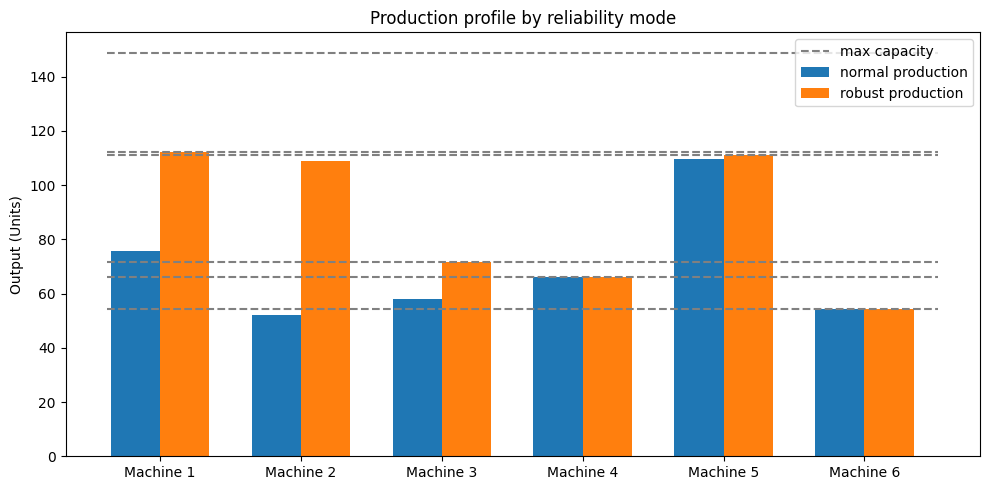

In [79]:
# Visual comparison of production decisions
modes = list(summaries.keys())
indices = np.arange(system.n)
width = 0.35

plt.figure(figsize=(10, 5))
for i, mode in enumerate(modes):
    plt.bar(indices + i * width, summaries[mode]["production"], width, label=f"{mode} production")

plt.hlines(system.u, xmin=-0.2, xmax=indices[-1] + len(modes) * width, colors="gray", linestyles="dashed", label="max capacity")
plt.xticks(indices + width / 2, [f"Machine {i+1}" for i in indices])
plt.ylabel("Output (Units)")
plt.title("Production profile by reliability mode")
plt.legend()
plt.tight_layout()
plt.show()

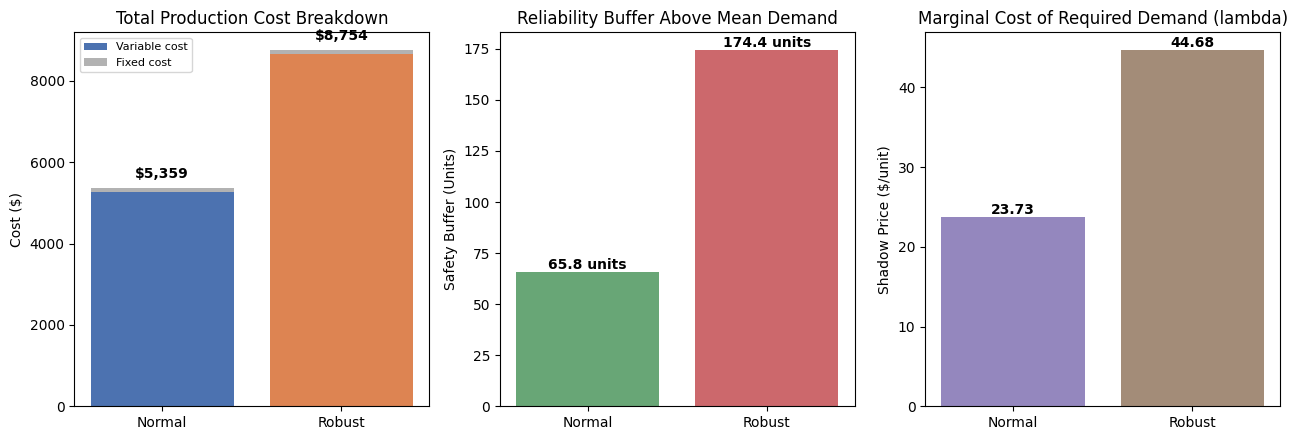

Robust planning holds about 108.6 extra safety units (buffer beyond mean) versus Normal.
Variable production cost increases by $3,394; total cost rises by $3,394 (≈ 63.3%).
Shadow price λ shifts from 23.73 to 44.68, indicating higher marginal cost pressure under the larger buffer.
Interpretation: The robust (distribution-free) assumption inflates the required production level, driving higher variable spend while fixed overhead remains unchanged.


In [80]:
# Enhanced cost & reliability comparison with economic breakdown
normal = results["normal"]
robust = results["robust"]

# Extract production vectors (used for variable cost breakdown if needed)
prod_normal = normal["x"]
prod_robust = robust["x"]

# Separate variable vs fixed cost components
fixed_cost = float(np.sum(system.gamma))  # same for both modes
var_cost_normal = float(np.sum(system.alpha * prod_normal**2 + system.beta * prod_normal))
var_cost_robust = float(np.sum(system.alpha * prod_robust**2 + system.beta * prod_robust))

total_normal = var_cost_normal + fixed_cost
total_robust = var_cost_robust + fixed_cost

# Effective demand buffers (safety units above mean)
buffers = [normal["D_eff"] - mu_D, robust["D_eff"] - mu_D]
labels = ["Normal", "Robust"]

# Shadow price (lambda) comparison: marginal cost of one more required unit
lambda_vals = [normal["lambda"], robust["lambda"]]

# Differences
extra_buffer = buffers[1] - buffers[0]
extra_var_cost = var_cost_robust - var_cost_normal
extra_total_cost = total_robust - total_normal
pct_increase_total = (extra_total_cost / total_normal) * 100 if total_normal > 0 else np.nan

plt.figure(figsize=(13, 4.5))

# Subplot 1: Cost breakdown stacked (variable vs fixed)
plt.subplot(1, 3, 1)
plt.bar(labels, [var_cost_normal, var_cost_robust], color=["#4C72B0", "#DD8452"], label="Variable cost")
plt.bar(labels, [fixed_cost, fixed_cost], bottom=[var_cost_normal, var_cost_robust], color="#808080", alpha=0.6, label="Fixed cost")
for i, (vc, tc) in enumerate(zip([var_cost_normal, var_cost_robust], [total_normal, total_robust])):
    plt.text(i, tc + max(total_normal, total_robust) * 0.02, f"${tc:,.0f}", ha="center", va="bottom", fontweight="bold")
plt.ylabel("Cost ($)")
plt.title("Total Production Cost Breakdown")
plt.legend(fontsize=8)

# Subplot 2: Reliability buffer units
plt.subplot(1, 3, 2)
plt.bar(labels, buffers, color=["#4D975E", "#C44E52"], alpha=0.85)
for i, b in enumerate(buffers):
    plt.text(i, b, f"{b:.1f} units", ha="center", va="bottom", fontweight="bold")
plt.ylabel("Safety Buffer (Units)")
plt.title("Reliability Buffer Above Mean Demand")
plt.axhline(0, color="black", linewidth=0.5)

# Subplot 3: Shadow price (lambda)
plt.subplot(1, 3, 3)
plt.bar(labels, lambda_vals, color=["#8172B3", "#937860"], alpha=0.85)
for i, lam in enumerate(lambda_vals):
    plt.text(i, lam, f"{lam:.2f}", ha="center", va="bottom", fontweight="bold")
plt.ylabel("Shadow Price ($/unit)")
plt.title("Marginal Cost of Required Demand (lambda)")

plt.tight_layout()
plt.show()

print(f"Robust planning holds about {extra_buffer:.1f} extra safety units (buffer beyond mean) versus Normal.")
print(f"Variable production cost increases by ${extra_var_cost:,.0f}; total cost rises by ${extra_total_cost:,.0f} (≈ {pct_increase_total:.1f}%).")
print(f"Shadow price λ shifts from {lambda_vals[0]:.2f} to {lambda_vals[1]:.2f}, indicating higher marginal cost pressure under the larger buffer.")
print("Interpretation: The robust (distribution-free) assumption inflates the required production level, driving higher variable spend while fixed overhead remains unchanged.")

## Analysis: Per-Machine Cost Curve Plot
The scatter points overlay each convex cost curve, showing chosen production under Normal vs Robust reliability buffering.
Robust mode generally shifts several machines to higher output, moving them further along the rising marginal cost region.
Machines with larger gaps between normal and robust points indicate where buffer requirements concentrate additional load.
Tighter clustering near curve minima suggests efficient allocation; divergence upward signals capacity pressure.
Shadow pricing trends align: higher robust outputs correlate with elevated marginal (lambda) pressure.
Overall, the plot visually justifies the cost premium of robustness via movement into steeper cost zones.

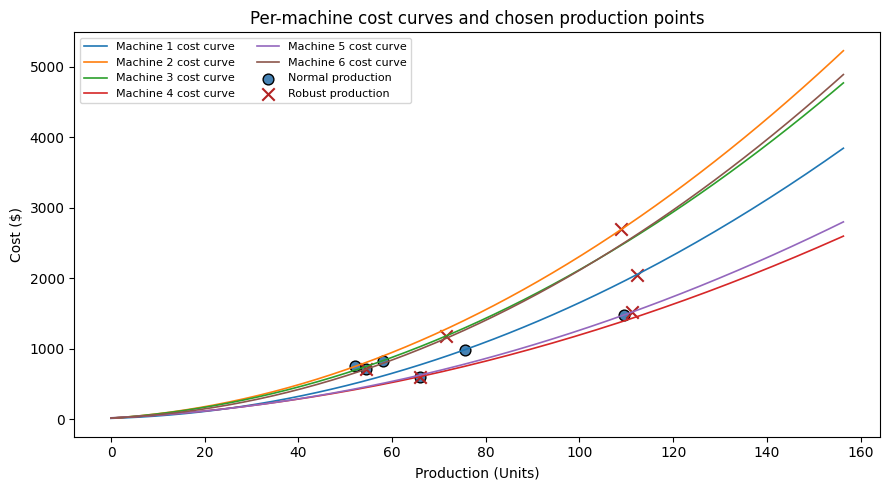

In [81]:
# Per-machine cost curves with chosen production points (Normal vs Robust)
import numpy as np
import matplotlib.pyplot as plt

# Ensure prerequisite objects exist: `system`, `results`
if 'system' not in globals() or 'results' not in globals():
    raise RuntimeError("Factory system or results dictionary is not defined. Run the scenario comparison cells first.")
if 'normal' not in results or 'robust' not in results:
    raise RuntimeError("Expected 'normal' and 'robust' keys in results. Run the comparison loop cell.")

x_plot = np.linspace(0, system.u.max() * 1.05, 200)
plt.figure(figsize=(9, 5))
for i in range(system.n):
    alpha_i = system.alpha[i]
    beta_i = system.beta[i]
    gamma_i = system.gamma[i]
    cost_curve = alpha_i * x_plot**2 + beta_i * x_plot + gamma_i
    plt.plot(x_plot, cost_curve, label=f"Machine {i+1} cost curve", linewidth=1.2)

# Production points for each reliability modeling mode
prod_normal = results['normal']['x']
prod_robust = results['robust']['x']
cost_normal = system.alpha * prod_normal**2 + system.beta * prod_normal + system.gamma
cost_robust = system.alpha * prod_robust**2 + system.beta * prod_robust + system.gamma

plt.scatter(prod_normal, cost_normal, marker='o', color='steelblue', edgecolor='black', s=60, label='Normal production')
plt.scatter(prod_robust, cost_robust, marker='x', color='firebrick', s=80, label='Robust production')

plt.title("Per-machine cost curves and chosen production points")
plt.xlabel("Production (Units)")
plt.ylabel("Cost ($)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

## Analysis: Demand vs Total Cost (Normal vs Robust)
The robust curve lies above the normal curve across feasible demand, reflecting larger reliability buffers inflating effective demand D_eff.
Both curves rise nonlinearly as mean demand increases, consistent with convex marginal costs at higher utilization.
Feasibility caps the domain at the smaller of normal/robust capacity thresholds; beyond this, D_eff would exceed installed capacity.
The gap between curves approximates the insurance premium for distributional ambiguity (robustness) at each demand level.
Local slope indicates the marginal cost of serving extra average demand; steeper segments imply tighter capacity.
Operational takeaway: robustness improves service assurance but incurs a predictable, demand‑dependent cost premium.

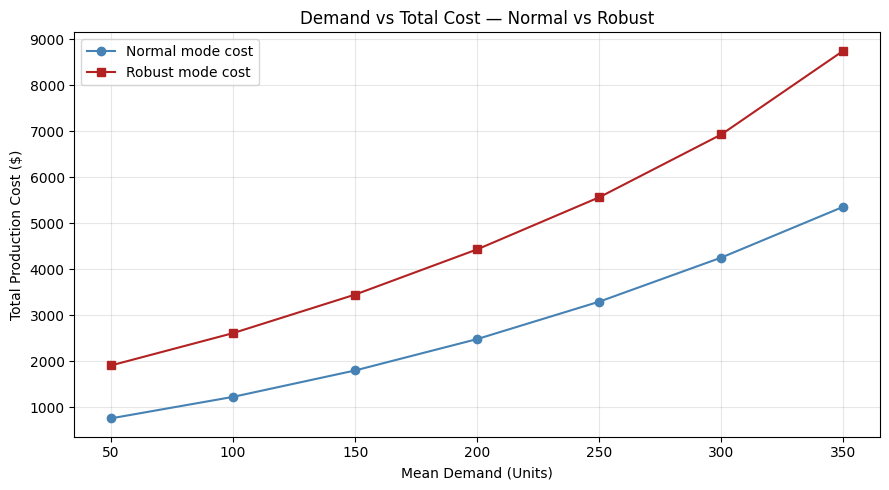

Sweep summary (first few rows):
   mean_demand  normal_cost  robust_cost  normal_D_eff  robust_D_eff
0         50.0   755.769390  1906.882330    115.794145    224.355958
1        100.0  1222.785287  2609.648043    165.794145    274.355958
2        150.0  1797.634014  3448.319936    215.794145    324.355958
3        200.0  2480.598824  4432.204745    265.794145    374.355958
4        250.0  3294.405001  5565.324280    315.794145    424.355958


In [82]:
# Demand vs Total Cost plot (Normal vs Robust)
import numpy as np
import matplotlib.pyplot as plt

# Preconditions
if 'system' not in globals():
    raise RuntimeError("'system' not found. Run the scenario comparison cell to create the ProductionSystem instance.")
if 'sigma_D' not in globals() or 'reliability' not in globals():
    raise RuntimeError("Expected 'sigma_D' and 'reliability' variables from earlier cells.")

sigma = sigma_D  # demand standard deviation (held constant)
rel = reliability

# Safety factors
z_score = stats.norm.ppf(rel)
k_robust = np.sqrt(rel / (1 - rel))  # Cantelli one-sided bound factor

# Maximum feasible mean demand for both modes (keep both solvable)
cap = system.total_capacity()
max_mu_normal = cap - z_score * sigma
max_mu_robust = cap - k_robust * sigma
max_mu = min(max_mu_normal, max_mu_robust)

# Choose a start demand (>=0) and build range in steps of 50 units
step = 50
start_mu = max(0, step) if max_mu >= step else 0
# Ensure at least one point
if start_mu > max_mu:
    raise ValueError("No feasible demand range given current buffer parameters and capacity.")

mu_values = np.arange(start_mu, max_mu + 1e-9, step)

normal_costs = []
robust_costs = []
normal_eff_demands = []
robust_eff_demands = []

for mu in mu_values:
    res_n = solve_dispatch(system, mu, sigma, reliability=rel, mode='normal')
    res_r = solve_dispatch(system, mu, sigma, reliability=rel, mode='robust')
    normal_costs.append(res_n['cost'])
    robust_costs.append(res_r['cost'])
    normal_eff_demands.append(res_n['D_eff'])
    robust_eff_demands.append(res_r['D_eff'])

plt.figure(figsize=(9,5))
plt.plot(mu_values, normal_costs, marker='o', label='Normal mode cost', color='steelblue')
plt.plot(mu_values, robust_costs, marker='s', label='Robust mode cost', color='firebrick')
plt.xlabel('Mean Demand (Units)')
plt.ylabel('Total Production Cost ($)')
plt.title('Demand vs Total Cost — Normal vs Robust')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#summary table (the values i got i am putting them as a table)
import pandas as pd
summary_df = pd.DataFrame({
    'mean_demand': mu_values,
    'normal_cost': normal_costs,
    'robust_cost': robust_costs,
    'normal_D_eff': normal_eff_demands,
    'robust_D_eff': robust_eff_demands,
})
print("Sweep summary (first few rows):")
print(summary_df.head())


### 6. Visualizing Risk Distributions

This plot compares the Gaussian demand distribution against the effective production targets derived from both "Normal" and "Robust" buffering strategies. It highlights how much "safety buffer" each method adds on top of the mean demand.

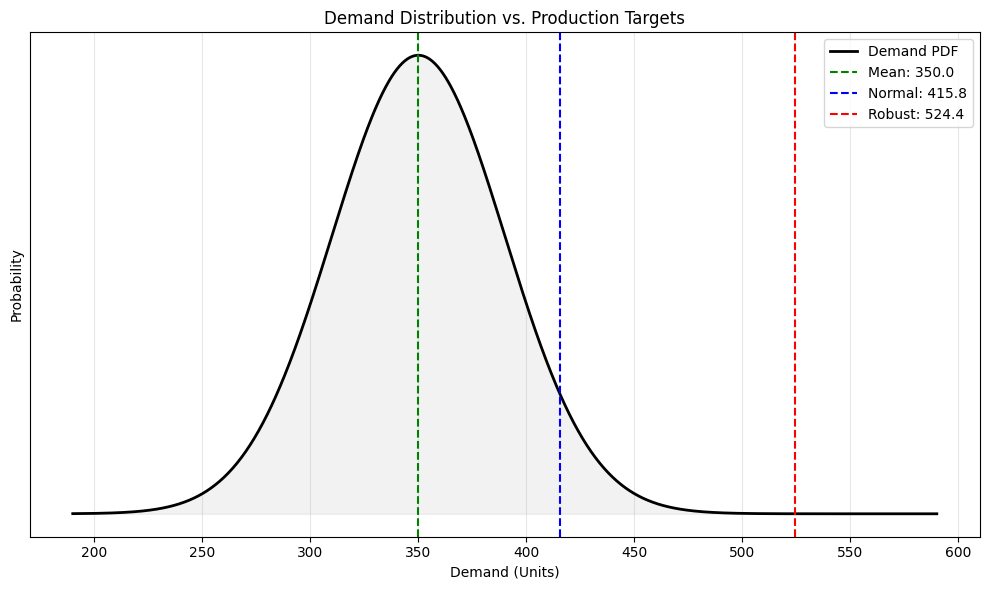

In [83]:
def plot_risk_distributions(mu, sigma, results):
    """Plots the demand distribution and compares it with production targets."""
    # 1. Demand Distribution
    x = np.linspace(mu - 4 * sigma, mu + 6 * sigma, 1000)
    y = stats.norm.pdf(x, mu, sigma)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'k-', lw=2, label='Demand PDF')
    plt.fill_between(x, y, alpha=0.1, color='gray')

    # 2. Targets
    plt.axvline(mu, color='green', linestyle='--', label=f'Mean: {mu:.1f}')
    
    d_norm = results['normal']['D_eff']
    plt.axvline(d_norm, color='blue', linestyle='--', label=f'Normal: {d_norm:.1f}')

    d_rob = results['robust']['D_eff']
    plt.axvline(d_rob, color='red', linestyle='--', label=f'Robust: {d_rob:.1f}')

    # 3. Style
    plt.xlabel('Demand (Units)')
    plt.ylabel('Probability')
    plt.title('Demand Distribution vs. Production Targets')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_risk_distributions(mu_D, sigma_D, results)

### 7. Sensitivity Analysis: Cost vs. Reliability

This section analyzes how the total production cost changes as we increase the target reliability level (e.g., from 90% to 99%). It contrasts the cost implications of the "Normal" (Gaussian-based) approach versus the "Robust" (Chebyshev/Cantelli-based) approach, filtering out reliability levels that would require production exceeding total system capacity.

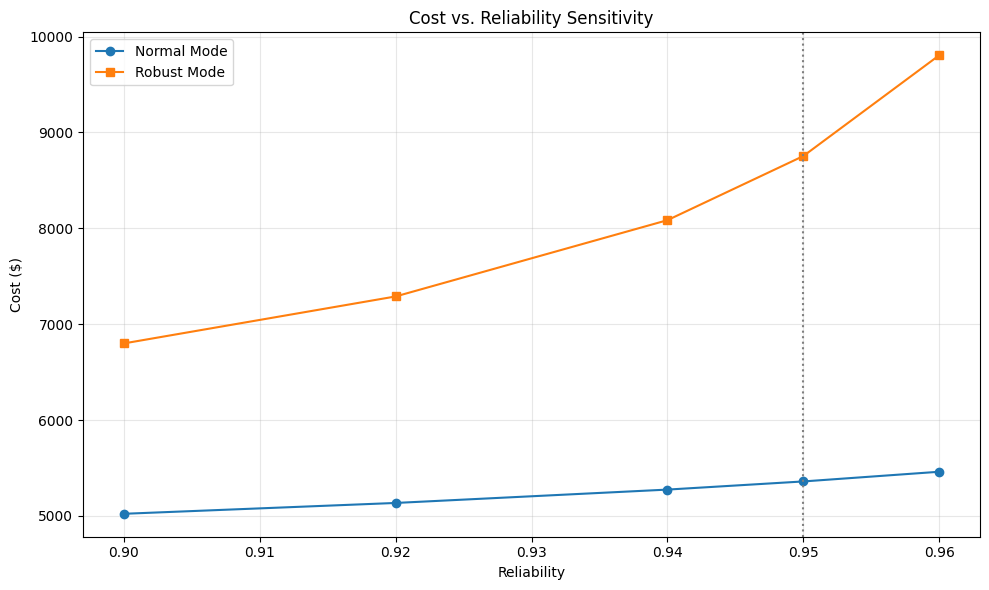


Sensitivity Results:
 Reliability  Normal  Robust
        0.90 5021.79 6799.29
        0.92 5134.91 7289.23
        0.94 5274.27 8084.87
        0.95 5359.32 8753.71
        0.96 5460.40 9805.08


In [84]:
def plot_sensitivity(system, mu, sigma, current_rel):
    """Analyzes how cost changes with reliability for Normal vs Robust modes."""
    # Range of reliabilities to test
    r_values = [0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
    cap = system.total_capacity()
    
    data = []
    for r in r_values:
        # Simple feasibility check
        z = stats.norm.ppf(r)
        k = np.sqrt(r / (1 - r))
        
        # Skip if demand exceeds capacity
        if (mu + z * sigma > cap) or (mu + k * sigma > cap):
            continue
            
        # Solve for both modes
        res_n = solve_dispatch(system, mu, sigma, r, mode="normal")
        res_r = solve_dispatch(system, mu, sigma, r, mode="robust")
        
        data.append({
            'Reliability': r,
            'Normal': res_n['cost'],
            'Robust': res_r['cost']
        })
    
    if not data:
        print("No feasible scenarios found.")
        return

    df = pd.DataFrame(data)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Reliability'], df['Normal'], 'o-', label='Normal Mode')
    plt.plot(df['Reliability'], df['Robust'], 's-', label='Robust Mode')
    
    plt.xlabel('Reliability')
    plt.ylabel('Cost ($)')
    plt.title('Cost vs. Reliability Sensitivity')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Mark current
    if current_rel in df['Reliability'].values:
        plt.axvline(current_rel, color='gray', linestyle=':', label='Current')
        
    plt.tight_layout()
    plt.show()
    
    # Simple table
    print("\nSensitivity Results:")
    print(df.to_string(index=False, float_format="%.2f"))

plot_sensitivity(system, mu_D, sigma_D, reliability)